In [1]:
#import libraries
import pandas as pd
pd.set_option('display.max_columns', 999)
import numpy as np
import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
color = sns.color_palette("hls", 20)
import lightgbm as lgb 

In [4]:
#import data
xls_file = pd.ExcelFile('C:\\Users\\Sonja\\Documents\\Python Scripts\\US HY jump risk\\data260917.xlsx')

**Prep data**

In [5]:
#parse sheet
data = xls_file.parse('data')
data.index = data['Date']
del data['Date']
data.shape

(7574, 59)

In [6]:
data.columns

Index([u'FDTR Index', u'VIX Index', u'USTW$ Index', u'USGG10YR Index',
       u'USGG30YR Index', u'USGG5YR Index', u'USYC2Y10 Index',
       u'USYC2Y30 Index', u'USYC5Y10 Index', u'USYC2Y5Y Index',
       u'CPI YOY Index', u'FDIDFDMO Index', u'USURTOT Index', u'NFP TCH Index',
       u'USEMNCHG Index', u'IP CHNG Index', u'MTIBCHNG Index', u'MGT2TB Index',
       u'PIDSPINX Index', u'NAPMPMI Index', u'OUTFGAF Index',
       u'USGGBE10 Index', u'USHBMIDX Index', u'CONCCONF Index',
       u'OEUSKLAR Index', u'RSTAMOM Index', u'USTBTOT Index', u'FDDSGDP Index',
       u'M2% YOY Index', u'CLA Comdty', u'CONSSENT Index', u'PIDSDPS Index',
       u'CICRTOT Index', u'ARDIMOYY Index', u'M1% YOY Index', u'SCGRRAI Index',
       u'EMB US Equity', u'SPE AUTO Index', u'SPE CARD Index', u'BFCIUS Index',
       u'INJCJMOM Index', u'LEI CHNG Index', u'GDP CYOY Index',
       u'SLDETIGT Index', u'SLDETGTS Index', u'GFSIFFND Index',
       u'XLF US Equity', u'XLE US Equity', u'XLK US Equity', u'XLV US E

In [10]:
#address data lags

#def Shift(indicator, d):
#    indicator.shift(d)
#    return

data['CPI YOY Index'] = data['CPI YOY Index'].shift(-11)
data['FDIDFDMO Index'] = data['FDIDFDMO Index'].shift(-10)
data['USURTOT Index'] = data['USURTOT Index'].shift(-4)
data['NFP TCH Index'] = data['NFP TCH Index'].shift(-4)
data['USEMNCHG Index'] = data['USEMNCHG Index'].shift(-4)
data['IP CHNG Index'] = data['IP CHNG Index'].shift(-17)
data['MTIBCHNG Index'] = data['MTIBCHNG Index'].shift(-15)
data['MGT2TB Index'] = data['MGT2TB Index'].shift(-15)
data['OUTFGAF Index'] = data['OUTFGAF Index'].shift(-17)
data['USHBMIDX Index'] = data['USHBMIDX Index'].shift(-15)
data['CONCCONF Index'] = data['CONCCONF Index'].shift(-29)
data['RSTAMOM Index'] = data['RSTAMOM Index'].shift(-15)
data['USTBTOT Index'] = data['USTBTOT Index'].shift(-4)
data['CONSSENT Index'] = data['CONSSENT Index'].shift(-18)
data['CICRTOT Index'] = data['CICRTOT Index'].shift(-7)
data['SPE AUTO Index'] = data['SPE AUTO Index'].shift(-30)
data['SPE CARD Index'] = data['SPE CARD Index'].shift(-30)
data['GDP CYOY Index'] = data['GDP CYOY Index'].shift(-30)

data = data.fillna(0)
data.shape

(7574, 59)

In [11]:
data['CPI YOY Index']

Date
1997-01-01    3.3
1997-01-02    3.3
1997-01-03    3.3
1997-01-04    3.3
1997-01-05    3.3
1997-01-06    3.3
1997-01-07    3.3
1997-01-08    3.3
1997-01-09    3.3
1997-01-10    3.3
1997-01-11    3.3
1997-01-12    3.3
1997-01-13    3.3
1997-01-14    3.3
1997-01-15    3.3
1997-01-16    3.3
1997-01-17    3.3
1997-01-18    3.3
1997-01-19    3.3
1997-01-20    3.3
1997-01-21    3.3
1997-01-22    3.3
1997-01-23    3.3
1997-01-24    3.3
1997-01-25    3.3
1997-01-26    3.3
1997-01-27    3.3
1997-01-28    3.3
1997-01-29    3.3
1997-01-30    3.3
             ... 
2017-08-28    1.7
2017-08-29    1.7
2017-08-30    1.7
2017-08-31    1.9
2017-09-01    1.9
2017-09-02    1.9
2017-09-03    1.9
2017-09-04    1.9
2017-09-05    1.9
2017-09-06    1.9
2017-09-07    1.9
2017-09-08    1.9
2017-09-09    1.9
2017-09-10    1.9
2017-09-11    1.9
2017-09-12    1.9
2017-09-13    1.9
2017-09-14    1.9
2017-09-15    1.9
2017-09-16    0.0
2017-09-17    0.0
2017-09-18    0.0
2017-09-19    0.0
2017-09-20    0.0
2017-

**Transform features**

In [12]:
#convert index to datetime object
data.index = pd.to_datetime(data.index)


In [13]:
# these are the transformations applied to each indicator
# the transformations of the n variables create n new columns of the transformed variable which then run through the classifiers
# add zscore formula to LevelChange and PctChange

from scipy import stats

window = [30, 90, 365, 1095, 1825]

def LevelChange (indicator, window): #calculate the monthly change in the indicator, window expressed in Months
    days=int(window)
    data[str(indicator)+' change in '+str(window)+'ds']=data[indicator]-data[indicator].shift(days)
    #data[str(indicator)+' change in '+str(window)+'ds' +'zscore']=stats.zscore(data[indicator], axis=None)
    
def PctChange (indicator,window): #calculate the monthly percentage change in the indicator, window expressed in Months
    days=int(window)
    data[str(indicator)+' %change in '+str(window)+'ds']=data[indicator]/data[indicator].shift(days)-1
    #data[str(indicator)+' change in '+str(window)+'ds' +'zscore']=stats.zscore(data[indicator], axis=None)
    
def Zscore (indicator,window):  # calculate a Z score over a number of trading days
    mean=data[indicator].rolling(window).mean()
    std=data[indicator].rolling(window).std()
    data[str(indicator)+str(window)+'zscore']=(data[indicator]-mean)/std
 

In [14]:
cols = list(data.columns)

for i in window:
    for col in cols:
        Zscore (col,i)


In [15]:
for i in window:
    LevelChange('FDTR Index', i)
    LevelChange('CPI YOY Index', i)
    LevelChange('IP CHNG Index', i)
    LevelChange('MGT2TB Index', i)
    LevelChange('NAPMPMI Index', i)
    LevelChange('OUTFGAF Index', i)
    LevelChange('USGGBE10 Index', i)
    LevelChange('USHBMIDX Index', i)
    LevelChange('CONCCONF Index', i)
    LevelChange('OEUSKLAR Index', i)
    LevelChange('FDDSGDP Index', i)
    LevelChange('M2% YOY Index', i)
    LevelChange('CONSSENT Index', i)
    LevelChange('PIDSDPS Index', i)
    LevelChange('CICRTOT Index', i)
    LevelChange('M1% YOY Index', i)
    LevelChange('SCGRRAI Index', i)
    LevelChange('LEI CHNG Index', i)
    LevelChange('GDP CYOY Index', i)
    LevelChange('GFSIFFND Index', i)
    LevelChange('CDX HY CDSI GEN 5Y SPRD Corp', i)
    LevelChange('PCUSEQTR Index', i)
    LevelChange('GFSIRLIQ Index', i)
    LevelChange('CIGMEMRA Index', i)
    LevelChange('CIGMGRAM Index', i)
    LevelChange('LF98OAS Index', i)
    LevelChange('USGG10YR Index',i)
    LevelChange('USGG30YR Index',i)
    LevelChange('USGG5YR Index',i)
    LevelChange('USYC2Y10 Index',i)
    LevelChange('USYC2Y30 Index',i)
    LevelChange('USYC5Y10 Index',i)
    LevelChange('USYC2Y5Y Index',i)

In [16]:
for i in window:
    PctChange('VIX Index',i)
    PctChange('USTW$ Index',i)
    PctChange('FDIDFDMO Index',i)
    PctChange('USEMNCHG Index',i)
    PctChange('MTIBCHNG Index',i)
    PctChange('PIDSPINX Index',i)
    PctChange('RSTAMOM Index',i)
    PctChange('USTBTOT Index',i)
    PctChange('CLA Comdty',i)
    PctChange('ARDIMOYY Index',i)
    PctChange('EMB US Equity',i)
    PctChange('SPE AUTO Index',i)
    PctChange('SPE CARD Index',i)
    PctChange('BFCIUS Index',i)
    PctChange('INJCJMOM Index',i)
    PctChange('SLDETIGT Index',i)
    PctChange('SLDETGTS Index',i)
    PctChange('XLF US Equity',i)
    PctChange('XLE US Equity',i)
    PctChange('XLK US Equity',i)
    PctChange('XLV US Equity',i)
    PctChange('XLI US Equity',i)
    PctChange('XLY US Equity',i)
    PctChange('XLB US Equity',i)

In [17]:
data.head(2)

,FDTR Index,VIX Index,USTW$ Index,USGG10YR Index,USGG30YR Index,USGG5YR Index,USYC2Y10 Index,USYC2Y30 Index,USYC5Y10 Index,USYC2Y5Y Index,CPI YOY Index,FDIDFDMO Index,USURTOT Index,NFP TCH Index,USEMNCHG Index,IP CHNG Index,MTIBCHNG Index,MGT2TB Index,PIDSPINX Index,NAPMPMI Index,OUTFGAF Index,USGGBE10 Index,USHBMIDX Index,CONCCONF Index,OEUSKLAR Index,RSTAMOM Index,USTBTOT Index,FDDSGDP Index,M2% YOY Index,CLA Comdty,CONSSENT Index,PIDSDPS Index,CICRTOT Index,ARDIMOYY Index,M1% YOY Index,SCGRRAI Index,EMB US Equity,SPE AUTO Index,SPE CARD Index,BFCIUS Index,INJCJMOM Index,LEI CHNG Index,GDP CYOY Index,SLDETIGT Index,SLDETGTS Index,GFSIFFND Index,XLF US Equity,XLE US Equity,XLK US Equity,XLV US Equity,XLI US Equity,XLY US Equity,XLB US Equity,CDX HY CDSI GEN 5Y SPRD Corp,PCUSEQTR Index,GFSIRLIQ Index,CIGMEMRA Index,CIGMGRAM Index,LF98OAS Index,FDTR Index30zscore,VIX Index30zscore,USTW$ Index30zscore,USGG10YR Index30zscore,USGG30YR Index30zscore,USGG5YR Index30zscore,USYC2Y10 Index30zscore,USYC2Y30 Index30zscore,USYC5Y10 Index30zscore,USYC2Y5Y Index30zscore,CPI YOY Index30zscore,FDIDFDMO Index30zscore,USURTOT Index30zscore,NFP TCH Index30zscore,USEMNCHG Index30zscore,IP CHNG Index30zscore,MTIBCHNG Index30zscore,MGT2TB Index30zscore,PIDSPINX Index30zscore,NAPMPMI Index30zscore,OUTFGAF Index30zscore,USGGBE10 Index30zscore,USHBMIDX Index30zscore,CONCCONF Index30zscore,OEUSKLAR Index30zscore,RSTAMOM Index30zscore,USTBTOT Index30zscore,FDDSGDP Index30zscore,M2% YOY Index30zscore,CLA Comdty30zscore,CONSSENT Index30zscore,PIDSDPS Index30zscore,CICRTOT Index30zscore,ARDIMOYY Index30zscore,M1% YOY Index30zscore,SCGRRAI Index30zscore,EMB US Equity30zscore,SPE AUTO Index30zscore,SPE CARD Index30zscore,BFCIUS Index30zscore,INJCJMOM Index30zscore,LEI CHNG Index30zscore,GDP CYOY Index30zscore,SLDETIGT Index30zscore,SLDETGTS Index30zscore,GFSIFFND Index30zscore,XLF US Equity30zscore,XLE US Equity30zscore,XLK US Equity30zscore,XLV US Equity30zscore,XLI US Equity30zscore,XLY US Equity30zscore,XLB US Equity30zscore,CDX HY CDSI GEN 5Y SPRD Corp30zscore,PCUSEQTR Index30zscore,GFSIRLIQ Index30zscore,CIGMEMRA Index30zscore,CIGMGRAM Index30zscore,LF98OAS Index30zscore,FDTR Index90zscore,VIX Index90zscore,USTW$ Index90zscore,USGG10YR Index90zscore,USGG30YR Index90zscore,USGG5YR Index90zscore,USYC2Y10 Index90zscore,USYC2Y30 Index90zscore,USYC5Y10 Index90zscore,USYC2Y5Y Index90zscore,CPI YOY Index90zscore,FDIDFDMO Index90zscore,USURTOT Index90zscore,NFP TCH Index90zscore,USEMNCHG Index90zscore,IP CHNG Index90zscore,MTIBCHNG Index90zscore,MGT2TB Index90zscore,PIDSPINX Index90zscore,NAPMPMI Index90zscore,OUTFGAF Index90zscore,USGGBE10 Index90zscore,USHBMIDX Index90zscore,CONCCONF Index90zscore,OEUSKLAR Index90zscore,RSTAMOM Index90zscore,USTBTOT Index90zscore,FDDSGDP Index90zscore,M2% YOY Index90zscore,CLA Comdty90zscore,CONSSENT Index90zscore,PIDSDPS Index90zscore,CICRTOT Index90zscore,ARDIMOYY Index90zscore,M1% YOY Index90zscore,SCGRRAI Index90zscore,EMB US Equity90zscore,SPE AUTO Index90zscore,SPE CARD Index90zscore,BFCIUS Index90zscore,INJCJMOM Index90zscore,LEI CHNG Index90zscore,GDP CYOY Index90zscore,SLDETIGT Index90zscore,SLDETGTS Index90zscore,GFSIFFND Index90zscore,XLF US Equity90zscore,XLE US Equity90zscore,XLK US Equity90zscore,XLV US Equity90zscore,XLI US Equity90zscore,XLY US Equity90zscore,XLB US Equity90zscore,CDX HY CDSI GEN 5Y SPRD Corp90zscore,PCUSEQTR Index90zscore,GFSIRLIQ Index90zscore,CIGMEMRA Index90zscore,CIGMGRAM Index90zscore,LF98OAS Index90zscore,FDTR Index365zscore,VIX Index365zscore,USTW$ Index365zscore,USGG10YR Index365zscore,USGG30YR Index365zscore,USGG5YR Index365zscore,USYC2Y10 Index365zscore,USYC2Y30 Index365zscore,USYC5Y10 Index365zscore,USYC2Y5Y Index365zscore,CPI YOY Index365zscore,FDIDFDMO Index365zscore,USURTOT Index365zscore,NFP TCH Index365zscore,USEMNCHG Index365zscore,IP CHNG Index365zscore,MTIBCHNG Index365zscore,MGT2TB Index365zscore,PIDSPINX Index365zscore,NAPMPMI Index365zscore,OUTFGAF Index365zscore,USGGBE1

In [20]:
data['Signal'] = data['LF98OAS Index change in 30ds'].shift(30)

In [21]:
# Transform target variable into binary classification

data['Signal'] = [1 if i >= 0.3 else 0 for i in data['Signal']]
 
data['Signal'].value_counts()


0    5997
1    1577
Name: Signal, dtype: int64

**Plot the classes**

([], <a list of 0 Text xticklabel objects>)

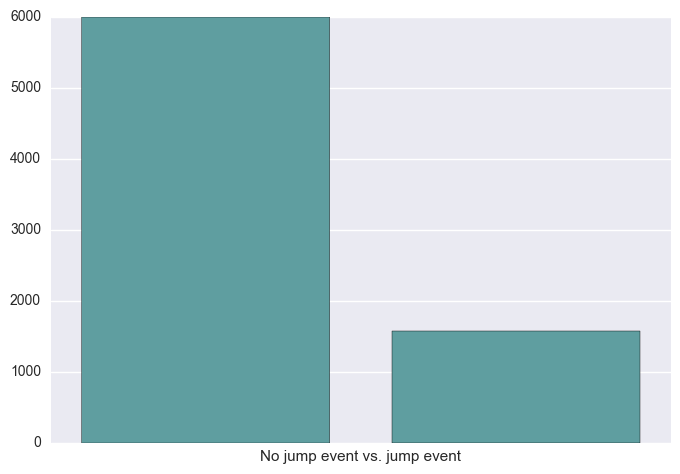

In [22]:
plt.hist(data['Signal'], bins=range(0,3), rwidth=0.8, color='cadetblue')

plt.xlabel(('No jump event vs. jump event'))
plt.xticks([])

*This is an imbalanced dataset - this needs addressing.*

**Define input and target variables**

In [23]:
y = data['Signal'].fillna(0)

#30, 90, 365, 1095, 1825
#LF98OAS Index
#LF98OAS Index90zscore
#LF98OAS Index180zscore
#LF98OAS Index360zscore
#LF98OAS Index change in 90dszscore
#LF98OAS Index change in 180dszscore
#LF98OAS Index change in 360dszscore

X = data.drop(['LF98OAS Index', 'LF98OAS Index change in 30ds','LF98OAS Index change in 90ds',\
          'LF98OAS Index change in 365ds', 'LF98OAS Index change in 1095ds',\
          'LF98OAS Index change in 1825ds','LF98OAS Index30zscore','LF98OAS Index90zscore',\
          'LF98OAS Index365zscore', 'LF98OAS Index1095zscore', 'LF98OAS Index1825zscore', 'Signal'], axis=1)


In [24]:
#check if X contains any column related to target variable

cols = list(X.columns)

for col in cols:
    if "LF98OAS" in col:
        print (col)

**Calculate class weights**

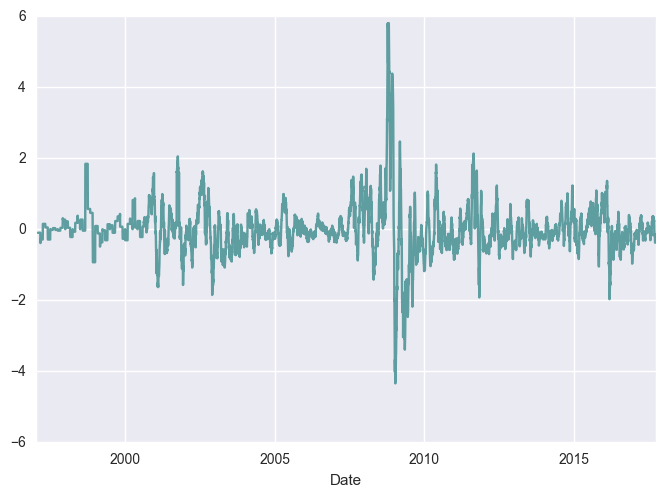

In [30]:
naive=data['LF98OAS Index change in 30ds'].value_counts()# naive prediction

data['LF98OAS Index change in 30ds'].plot(color='cadetblue')

In [31]:
def weight(cl):
    if cl==1:
        return naive[0].astype(float)/naive[1].astype(float)
    else:
        return 1

wgt = y.apply(weight)


In [32]:
wgt.value_counts()

1.000000     5997
24.666667    1577
Name: Signal, dtype: int64

In [33]:
#address inf and nan values
X = X.replace([np.inf, -np.inf], np.nan).fillna(0)


**XGBoost**

In [34]:
#split out training and testing sets (0.7 training, 0.3 testing)

X_train = X[:5301]
y_train = y[:5301]
X_test = X[5301:]
y_test = y[5301:]
y_test.value_counts()

0    1801
1     472
Name: Signal, dtype: int64

In [35]:
# Run XGBoost model on train & test sets

train_data = lgb.Dataset(X_train, y_train) 
test_data = lgb.Dataset(X_test, y_test, reference=train_data)   

In [36]:
# setting up parameters - more details at https://github.com/Microsoft/LightGBM/blob/master/docs/Parameters.md

param = {
        'task': 'train',
        'boosting_type': 'gbdt',
        'objective': 'binary', # one class to predict
        'num_classes': 1,
        'metric': 'auc', 
        'max_depth': 20,# was 10
        'learning_rate': 0.01,
        'feature_fraction': 0.8,
        'bagging_fraction': 0.8,
        'num_thread':1,
        'bagging_freq': 5,
        'verbose': 0,
        'num_iterations':80, # number of features
        'is_unbalance':True,
        'early_stopping_round':5 # stops if no improvement after 5 iterations
        }

num_round = 2000 # number of iterations

lgb.cv(param, train_data, num_round, nfold=5) # crossvalidates with 5 folds for selection
bst = lgb.train(param, train_data, num_round, valid_sets=[test_data] )

[1]	valid_0's auc: 0.610828
[2]	valid_0's auc: 0.605445
[3]	valid_0's auc: 0.63263
[4]	valid_0's auc: 0.67
[5]	valid_0's auc: 0.673148
[6]	valid_0's auc: 0.678981
[7]	valid_0's auc: 0.678121
[8]	valid_0's auc: 0.676673
[9]	valid_0's auc: 0.657454
[10]	valid_0's auc: 0.657715
[11]	valid_0's auc: 0.659842
[12]	valid_0's auc: 0.687986
[13]	valid_0's auc: 0.694659
[14]	valid_0's auc: 0.679909
[15]	valid_0's auc: 0.677109
[16]	valid_0's auc: 0.683637
[17]	valid_0's auc: 0.690691
[18]	valid_0's auc: 0.711023
[19]	valid_0's auc: 0.698251
[20]	valid_0's auc: 0.706344
[21]	valid_0's auc: 0.715225
[22]	valid_0's auc: 0.724991
[23]	valid_0's auc: 0.722469
[24]	valid_0's auc: 0.720834
[25]	valid_0's auc: 0.720348
[26]	valid_0's auc: 0.710952
[27]	valid_0's auc: 0.711625
[28]	valid_0's auc: 0.72339
[29]	valid_0's auc: 0.725401
[30]	valid_0's auc: 0.716891
[31]	valid_0's auc: 0.712676
[32]	valid_0's auc: 0.714567
[33]	valid_0's auc: 0.714078
[34]	valid_0's auc: 0.715726
[35]	valid_0's auc: 0.715408


**Plotting model performance**

In [37]:
feats = pd.DataFrame(bst.feature_importance())
feats.columns = ['feature importance']
feature_name = bst.feature_name()
feats['name'] = feature_name
featssorted = feats.sort_values(['feature importance'], ascending=False)
top_feats = featssorted[0:50]

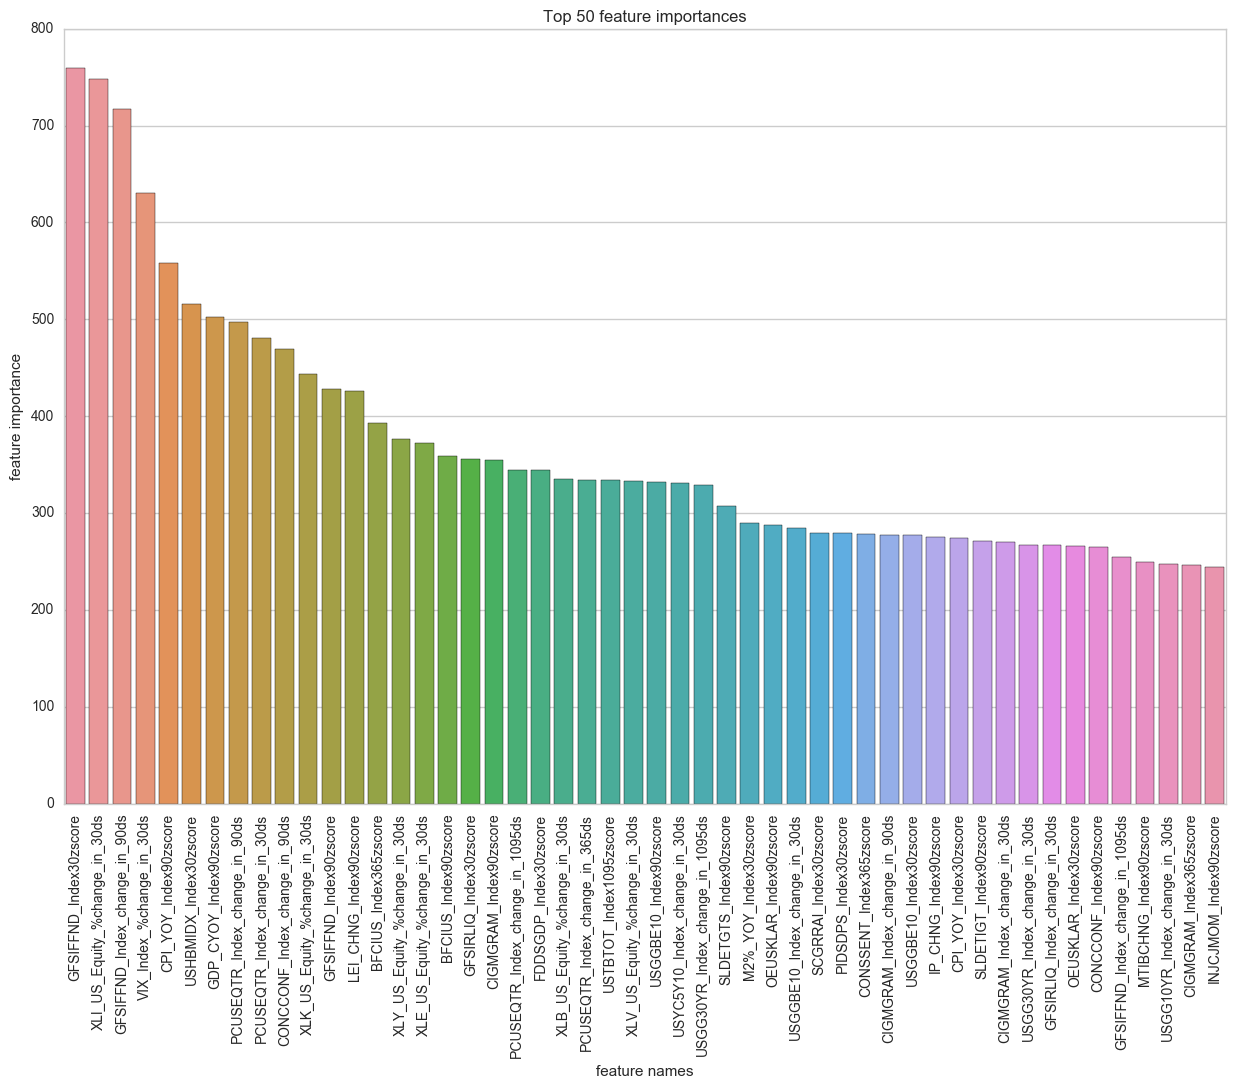

In [38]:
# Plot feature importances

sns.set(style='whitegrid')

f, ax = plt.subplots(figsize=(15,10))
ax = sns.barplot(x=top_feats['name'], y=top_feats['feature importance'])
ax.set(xlabel='feature names', ylabel='feature importance')
ax.set_title('Top 50 feature importances')
for item in ax.get_xticklabels():
    item.set_rotation(90)

**Plot AUC-Roc curve**

In [39]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

y_pred = bst.predict(X_test)
y_pred

AUC = roc_auc_score(y_test, y_pred)

fpr, tpr, threshold = roc_curve(y_test, y_pred)


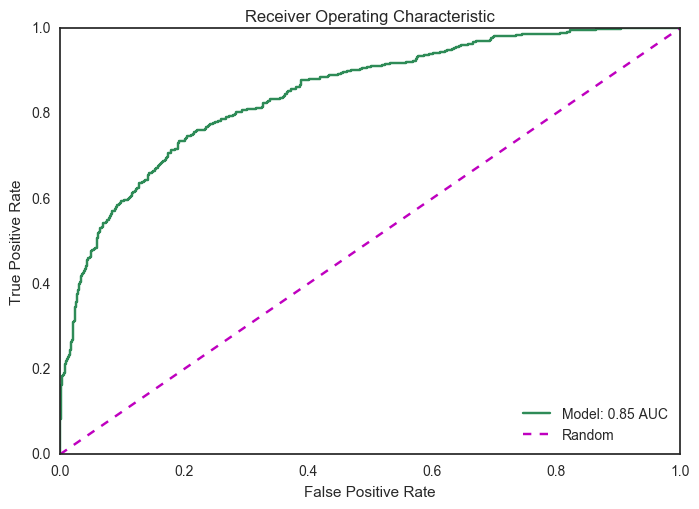

In [40]:
sns.set_style("white")

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'seagreen', label='Model: %0.2f AUC' % AUC)
plt.plot([0, 1], [0, 1],'m--', label='Random')
plt.legend(loc = 'lower right')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()